In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import datetime
from datetime import datetime
from numpy import nan
import string 
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import warnings
from numpy import loadtxt
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')
%matplotlib inline
import random
from sklearn.model_selection import  train_test_split
import matplotlib as mpl

In [2]:
dataset = pd.read_csv(
    '附件4：门店交易训练数据.txt',
    sep="\t",
    header=None,
    names=['carid','pushDate','pushPrice','updatePriceTimeJson','pullDate','withdrawDate']
)

carmessage = pd.read_csv(
    'price - 副本.csv'
)

carmessage


,carid,tradeTime,brand,serial,model,mileage,color,cityId,carCode,transferCount,...,registerDate,licenseDate,country,maketype,modelyear,displacement,gearbox,oiltype,newprice,price
0,19478,08/04/2020,106,899,4350,0.01,2,1,4.0,1,...,02/01/2020,05/12/2020,NaN,NaN,2018.0,6.7,14.0,1,610.00,678.80
1,54999,09/14/2020,8,208,9962,6.15,3,19,2.0,1,...,01/01/2012,03/19/2012,779412.0,2.0,2012.0,1.4,31.0,1,16.78,658.00
2,23427,04/09/2021,100,947,5008,0.43,2,1,1.0,0,...,07/01/2017,01/10/2018,779411.0,3.0,2017.0,6.8,13.0,1,495.00,596.00
3,30951,08/04/2020,106,1014,6178,0.13,1,1,1.0,0,...,07/01/2019,05/14/2020,NaN,NaN,2018.0,6.6,13.0,1,505.00,528.80
4,16359,08/04/2020,106,863,3790,1.67,2,1,1.0,1,...,03/01/2017,08/03/2017,NaN,NaN,2018.0,6.6,13.0,1,520.00,459.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,21556,11/29/2020,1,798,4709,14.45,7,19,3.0,0,...,10/01/2008,12/19/2008,779416.0,2.0,2008.0,0.8,6.0,1,4.02,0.26
29995,1335,06/23/2021,25,397,1149,7.04,4,1,2.0,1,...,05/01/2010,06/24/2010,779413.0,1.0,2010.0,1.0,6.0,1,3.99,0.19
29996,481,07/17/2021,10,266,453,18.58,2,5,3.0,1,...,03/01/2009,04/02/2009,779413.0,1.0,2007.0,1.6,6.0,1,6.98,0.15
29997,31,06/02/2021,21,28,31,9.56,7,2,2.0,0,...,09/01/2010,11/24/2010,779413.0,1.0,2009.0,1.0,6.0,1,4.68,0.10


In [3]:
dataset

,carid,pushDate,pushPrice,updatePriceTimeJson,pullDate,withdrawDate
0,68603,2021-03-11,3.9800,{},2021-03-11,2021-03-11
1,12312,2021-05-14,4.5000,{},2021-06-14,2021-06-14
2,57655,2021-03-13,23.9000,"{""2021-04-05"": ""23""}",2021-04-08,2021-04-08
3,45688,2020-09-01,20.5798,{},2020-09-04,2020-09-04
4,52081,2021-04-29,12.2800,"{""2021-05-20"": ""11.9""}",2021-06-21,2021-06-21
...,...,...,...,...,...,...
9995,10177,2021-07-31,22.8800,{},2021-09-11,NaN
9996,54312,2021-03-22,12.3000,{},2021-04-16,NaN
9997,45597,2021-01-09,15.3800,{},2021-01-27,NaN
9998,38629,2021-06-07,36.8800,"{""2021-06-12"": ""36.6""}",2021-06-22,NaN


In [4]:
#根据dateset.withdrawDate与dateset.withdrawDate是否相等 添加是否成交属性（dealornot）
dataset.loc[:,"dealornot"] = 0
dataset.loc[(dataset.withdrawDate==dataset.pullDate),'dealornot'] = 1
dataset.loc[(dataset.withdrawDate!=dataset.pullDate),'dealornot'] = 0

#根据dealornot是否为0 采用当前时间补全成交时间缺失项
dataset.loc[(dataset.dealornot==0),'withdrawDate'] = datetime.now().strftime('%F')

#构造在架时间列
dataset.loc[:,"sellingTime"] = pd.to_datetime(dataset["pullDate"]) - pd.to_datetime(dataset["pushDate"])
dataset.loc[:,"sellingTime"] = dataset.sellingTime.astype('str').apply(lambda x:x[:-5]).astype('int32')

#将数据中上架时间由年月日转换为 年（pushyear） 月（pushmonth） 日（pushday）
#(不要)#将数据中成交时间由年月日转换为 年（withdrawyear） 月（withdrawmonth） 日（withdrawday）
dt1= dataset["pushDate"]
dt1= dt1.apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
dataset["pushyear"] = dt1.map(lambda x: x.year)
dataset["pushmonth"] = dt1.map(lambda x: x.month)
dataset["pushday"] = dt1.map(lambda x: x.day)


#构造新的列 成交周期（dealTime）通过to_datetime()实现日期相减，通过astype()实现数据类型转换，转换为整数（int32）
dataset.loc[:,"dealTime"] = pd.to_datetime(dataset["withdrawDate"]) - pd.to_datetime(dataset["pushDate"])
#dataset.dealTime.fillna(pd.Timedelta(seconds=0),inplace=True)#将缺失数据（NaT补成0）
dataset.loc[:,"dealTime"] = dataset.dealTime.astype('str').apply(lambda x:x[:-5]).astype('int32')
dataset


#调价时间 调价价格处理

updatedata = dataset.updatePriceTimeJson
updatedata = updatedata.str.strip('{}')
updatedata = updatedata.str.replace(',','@')
updatedata = updatedata.str.strip('')
updatedata = updatedata.to_frame()
updatedata.columns =["updatePriceTimeJson"]
updatedata['updatePriceTimeJson']= updatedata['updatePriceTimeJson'].str.strip('')

for index in updatedata['updatePriceTimeJson'].index:
    getdata = updatedata['updatePriceTimeJson'] .get(index)
    getdata = getdata[::-1]
    #print(getdata)
    updatedata.loc[index,"updatePriceTimeJson"] = getdata

#updatedata['A']= updatedata['updatePriceTimeJson'].str.split('@')
#updatedata['B']= updatedata['updatePriceTimeJson'].str.split(',').str

updatedata=updatedata['updatePriceTimeJson'].str.split('@', expand=True)
#updatedata.join(updatedata['updatePriceTimeJson'].str.split('@', expand=True))
#pd.concat([updatedata, updatedata['A'].str.split(',', expand=True)], axis=1,names=new_names)
#updatedata[::1] = updatedata[::-1] 


#ype(updatedata)
#updatedata = pd.DataFrame(list(updatedata.map(lambda x: x.split()),columns = ['1','2','3','4','5']))
#updatedata = updatedata[:]

updatedata = updatedata[0]
updatedata = updatedata.to_frame()
for index in updatedata[0].index:
    getdata = updatedata[0] .get(index)
    getdata = getdata[::-1]
    updatedata.loc[index,0] = getdata

    
updatedata=updatedata[0].str.split(':', expand=True)
updatedata.columns =["adjusttime","adjustprice"]
updatedata['adjusttime'] = updatedata['adjusttime'].str.strip('')
updatedata['adjusttime'] = updatedata['adjusttime'].str.replace('"','')
updatedata['adjustprice'] = updatedata['adjustprice'].str.replace('"','')   
updatedata['adjusttime'] = updatedata['adjusttime'].str.strip('') 
updatedata['adjustprice'] = updatedata['adjustprice'].str.strip('')



updatedata.loc[(updatedata.adjusttime==''),'adjusttime'] = dataset.pushDate
updatedata.loc[(updatedata.adjusttime==dataset.pushDate),'adjustprice'] = dataset.pushPrice

#将修改好的updatedata 合并到dataset中
dataset.loc[:,"lastadjusttime"]=updatedata.loc[:,"adjusttime"]
dataset.loc[:,"lastadjustprice"]=updatedata.loc[:,"adjustprice"]


#删除调整时间列（updatePriceTimeJson）

#dataset.drop('updatePriceTimeJson',axis=1,inplace=True)

dataset.loc[0:50]
#print(updatedata[:,-1])

#添加调整周期（adjusttime）与调整幅度（adjustratio）列

dataset.loc[:,"adjusttime"] = pd.to_datetime(dataset["lastadjusttime"]) - pd.to_datetime(dataset["pushDate"])
dataset.loc[:,"adjusttime"] = dataset.adjusttime.astype('str').apply(lambda x:x[:-5]).astype('int32')


for n in range(10000):
    dataset.loc[n,"lastadjustprice"] = float(dataset.loc[n,"lastadjustprice"])


#dataset.loc[:,"adjustratio"] = (float(dataset.loc[index,"lastadjustprice"])/float(dataset.loc[index,"pushPrice"]))
#修改为百分制
dataset.loc[:,"adjustratio"] = (float(dataset.loc[index,"lastadjustprice"])/float(dataset.loc[index,"pushPrice"]))*100

#dataset



In [5]:
dataset.loc[dataset.dealornot==True,'dealTime'].describe()

count    8000.000000
mean       21.534375
std        27.046872
min         0.000000
25%         5.000000
50%        13.000000
75%        28.000000
max       263.000000
Name: dealTime, dtype: float64

In [7]:
dataset.loc[dataset.dealornot==False,'dealTime'].describe()

count    2000.000000
mean      399.272000
std       137.958419
min       173.000000
25%       280.000000
50%       394.000000
75%       507.000000
max       749.000000
Name: dealTime, dtype: float64

4368

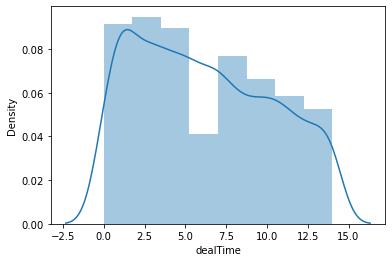

In [8]:
#fig,axes=plt.subplots(1,2)
#sns.distplot(dataset.loc[dataset.dealornot==True,'dealTime'],kde=True,bins=50)
dataset.loc[(dataset.dealornot==True)&(dataset.dealTime>=0)&(dataset.dealTime<=1),'dealTime']
sns.distplot(dataset.loc[(dataset.dealornot==True)&(dataset.dealTime>=0)&(dataset.dealTime<=14),'dealTime'],bins=8)
len(dataset.loc[(dataset.dealornot==True)&(dataset.dealTime>=0)&(dataset.dealTime<=14),'dealTime'])

In [9]:
#将数据根据是否成交（dealornot）拆分成成交dealdata和未成交notdealdata
dealdata = dataset.loc[(dataset.dealornot==True),:]
notdealdata = dataset.loc[dataset.dealornot==False,:]

#根据carid 将附件1数据carmessage 和附件4数据 dealdata
alldealdata = pd.merge(dealdata,carmessage,on='carid')
alldealdata

#得到需要进行相关性分析的数据
dealdatatest=dealdata[['pushyear','pushPrice','pushmonth','pushday','dealTime','lastadjustprice','adjusttime','adjustratio']]
#alldealdatatest = alldealdata[['dealTime','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']]

alldealdatatest = alldealdata[['carid','dealTime','pushyear','pushPrice','pushmonth','pushday','lastadjustprice','adjusttime','adjustratio','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']]

#处理数据
for m in range(8000):
    if alldealdatatest.loc[m,"maketype"]==alldealdatatest.loc[m,"maketype"]:
         alldealdatatest.loc[m,"maketype"] = int(alldealdatatest.loc[m,"maketype"])
    else:
         alldealdatatest.loc[m,"maketype"]=0
            
for m in range(8000):
    alldealdatatest.loc[m,"pushyear"] = int(alldealdatatest.loc[m,"pushyear"])
    alldealdatatest.loc[m,"pushmonth"] = int(alldealdatatest.loc[m,"pushmonth"])
    alldealdatatest.loc[m,"pushday"] = int(alldealdatatest.loc[m,"pushday"])
    alldealdatatest.loc[m,"lastadjustprice"] = float(alldealdatatest.loc[m,"lastadjustprice"])

#附件4数据的均值方差归一化
# 创建一个均值方差归一化对象
std_scaler = StandardScaler()

# 计算均值和方差
std_scaler.fit(dealdatatest)
# 归一化转化
dealdatatest = std_scaler.transform(dealdatatest)

dealdatatest = pd.DataFrame(dealdatatest)
dealdatatest.columns= ['pushyear','pushPrice','pushmonth','pushday','dealTime','lastadjustprice','adjusttime','adjustratio']

print(dealdatatest)


#附件1和4数据的均值方差归一化
# 创建一个均值方差归一化对象
#std_scaler2 = StandardScaler()

# 计算均值和方差
#std_scaler2.fit(alldealdatatest)
# 归一化转化
#alldealdatatest = std_scaler2.transform(alldealdatatest)

#alldealdatatest = pd.DataFrame(alldealdatatest)
#alldealdatatest.columns= ['dealTime','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']
#print(alldealdatatest)


#全部的附件1和4数据的均值方差归一化
# 创建一个均值方差归一化对象
std_scaler2 = StandardScaler()

# 计算均值和方差
std_scaler2.fit(alldealdatatest)
# 归一化转化
alldealdatatest = std_scaler2.transform(alldealdatatest)

alldealdatatest = pd.DataFrame(alldealdatatest)
alldealdatatest.columns= ['carid','dealTime','pushyear','pushPrice','pushmonth','pushday','lastadjustprice','adjusttime','adjustratio','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']
print(alldealdatatest)






      pushyear  pushPrice  pushmonth   pushday  dealTime  lastadjustprice  \
0     1.253273  -0.616026  -1.107583 -0.596212 -0.796237        -0.604296   
1     1.253273  -0.582677  -0.445401 -0.243258  0.349993        -0.570798   
2     1.253273   0.661476  -1.107583 -0.360909  0.165117         0.620934   
3    -0.797911   0.448546   0.878965 -1.772722 -0.685312         0.465030   
4     1.253273  -0.083733  -0.776492  1.521508  1.163447        -0.094105   
...        ...        ...        ...       ...       ...              ...   
7995  1.253273  -0.141452  -0.445401  1.639159 -0.315560        -0.152082   
7996 -0.797911  -0.250476  -0.776492 -0.478561  7.264349        -0.256439   
7997 -0.797911  -0.614743   0.547873 -0.831514 -0.426485        -0.615891   
7998 -0.797911  -0.558307   1.210056 -0.831514 -0.648336        -0.546320   
7999 -0.797911  -0.486480   1.541147 -0.243258 -0.759262        -0.474171   

      adjusttime  adjustratio  
0      -0.401148          0.0  
1      -0.4

<AxesSubplot:xlabel='dealTime', ylabel='Density'>

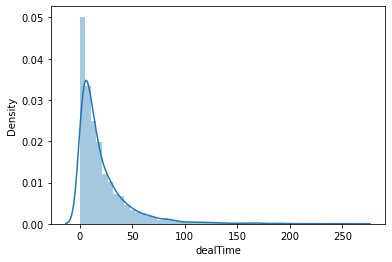

In [10]:
sns.distplot(dataset.loc[dataset.dealornot==True,'dealTime'])

[0.05845841 0.05025252 0.04655927 0.04588564 0.04955643 0.04949582
 0.04730551 0.04764297 0.04843232 0.0533087  0.04826286 0.05169077
 0.05460035 0.05412573 0.05346252 0.04920177 0.04958518 0.0498281
 0.04424939 0.04809579]
[100.        55.543865  35.53542   31.885954  51.772785  51.4444
  39.57823   41.40642   45.682804  72.10101   44.76474   63.335735
  79.09864   76.527306  72.934326  49.85135   51.92851   53.24456
  23.021425  43.859615]


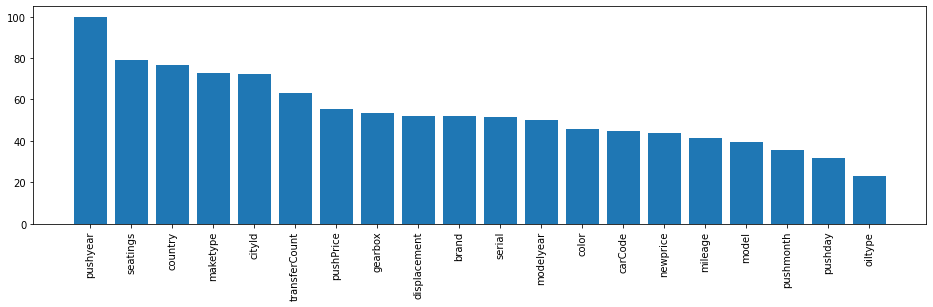

In [11]:

#alldealdatatest = alldealdata[['dealTime','pushyear','pushPrice','pushmonth','pushday','lastadjustprice','adjusttime','adjustratio','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']]



x = alldealdatatest[['pushyear','pushPrice','pushmonth','pushday','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']]
y = alldealdatatest[['dealTime']]
model = XGBClassifier(eval_metric=['logloss','auc','error'])
model.fit(x,y)
fea_imp = model.feature_importances_
#fea_imp = 100*((fea_imp-min(fea_imp))/max(fea_imp-min(fea_imp)))
#fea_imp = 100*((fea_imp-np.mean(fea_imp))/max(fea_imp-min(fea_imp)))
fea_imp = 100*((fea_imp-0.04)/max(fea_imp-0.04))
print(model.feature_importances_)
print(fea_imp)
index_sorted = np.argsort(-fea_imp) # 降序排列
plt.figure(figsize=(16,4))
#统计非0的个数
n = (fea_imp[index_sorted]>0).sum()
#让X坐标轴上的标签居中显示 和n保持一致
pos = np.arange(n)+0.5

fea=['pushyear','pushPrice','pushmonth','pushday','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']

plt.xticks(pos,np.array(fea)[index_sorted][:n],rotation=90) # 转90度就可以了！
plt.bar(pos,fea_imp[index_sorted][:n],align='center')
plt.show()


In [12]:
#pushyear这个影响因素是客观的，是市场的发展趋势，把这个因素去除，对其他数据进行直接的统计分析
#首先要统计都有哪些上一个分析的结果，先直接统计每个非数值意义变量的类型
#将变量类型转为list（）
#maketype

alldealdatatest = alldealdata[['dealTime','pushyear','pushPrice','pushmonth','pushday','lastadjustprice','adjusttime','adjustratio','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']]

for m in range(8000):
    if alldealdatatest.loc[m,"maketype"]==alldealdatatest.loc[m,"maketype"]:
         alldealdatatest.loc[m,"maketype"] = int(alldealdatatest.loc[m,"maketype"])
    else:
         alldealdatatest.loc[m,"maketype"]=0

#统计均值
maketypedata = alldealdatatest[['maketype','dealTime']]
#data = alldealdatatest.groupby('maketype')['dealTime'].sum()
#maketypedata = alldealdatatest.groupby('maketype').agg({'dealTime':{'max','min','mean'}})


pushyearhdata = alldealdatatest.groupby('pushyear')['dealTime'].describe()
print(pushyearhdata)
pushmonthdata = alldealdatatest.groupby('pushmonth')['dealTime'].describe()
print(pushmonthdata)
notdealpushmonthdata = notdealdata.groupby('pushmonth')['dealTime'].describe()
print(notdealpushmonthdata)

pushdaydata = alldealdatatest.groupby('pushday')['dealTime'].describe()
print(pushdaydata)


pushPricedata = alldealdatatest.groupby('pushPrice')['dealTime'].describe()
print(pushPricedata)

milagedata = alldealdatatest.groupby('mileage')['dealTime'].describe()
print(milagedata)
modeldata = alldealdatatest.groupby('model')['dealTime'].describe()
print(modeldata)
serialdata = alldealdatatest.groupby('serial')['dealTime'].describe()
print(serialdata)
colordata = alldealdatatest.groupby('color')['dealTime'].describe()
print(colordata)


maketypedata = alldealdatatest.groupby('maketype')['dealTime'].describe()
print(maketypedata)
countrydata = alldealdatatest.groupby('country')['dealTime'].describe()
print(countrydata)
seatingsdata = alldealdatatest.groupby('seatings')['dealTime'].describe()
print(seatingsdata)
cityIddata = alldealdatatest.groupby('cityId')['dealTime'].describe()
print(cityIddata)
oiltypedata = alldealdatatest.groupby('oiltype')['dealTime'].describe()
print(oiltypedata)
branddata = alldealdatatest.groupby('brand')['dealTime'].describe()
print(branddata)
modelyeardata = alldealdatatest.groupby('modelyear')['dealTime'].describe()
print(modelyeardata)


pd.set_option('display.max_rows', None)
type(cityIddata)
#cityIddata.columns= ['count','mean','std','min','25%','50%','75%','max']
#cityIddata = cityIddata.loc[:,cityIddata.count>=40]

cityIddata = cityIddata.sort_values(by='count', ascending=True)
print(cityIddata)
branddata = branddata.sort_values(by='count', ascending=True)
print(branddata)
print(pushPricedata)


           count       mean        std  min  25%   50%   75%    max
pushyear                                                           
2020      4888.0  23.465221  29.961977  0.0  6.0  14.0  29.0  263.0
2021      3112.0  18.501607  21.345981  0.0  4.0  11.0  25.0  190.0
            count       mean        std  min  25%   50%    75%    max
pushmonth                                                            
1           488.0  28.842213  27.550024  0.0  7.0  23.0  42.25  189.0
2           298.0  22.573826  30.820370  0.0  6.0  13.5  26.00  244.0
3           679.0  20.734904  32.031564  0.0  4.5  10.0  25.00  263.0
4           940.0  24.160638  32.829711  0.0  5.0  13.0  27.00  234.0
5           919.0  22.655060  29.872563  0.0  4.0  12.0  29.50  212.0
6          1003.0  20.808574  25.212930  0.0  5.0  12.0  27.50  239.0
7          1091.0  20.762603  23.300618  0.0  5.0  13.0  28.00  192.0
8           552.0  21.362319  27.134187  0.0  6.0  13.0  26.25  237.0
9           574.0  18.515679

         count        mean        std    min     25%    50%    75%    max
cityId                                                                   
1       2986.0   15.122237  16.251194    0.0    4.00   10.0   20.0  161.0
2        175.0   28.708571  36.133544    0.0    5.00   14.0   40.0  167.0
3        567.0   25.379189  28.548312    0.0    6.00   16.0   34.0  189.0
4        396.0   31.174242  30.351484    0.0    9.75   22.0   43.0  239.0
5        294.0   24.513605  27.303217    0.0    7.00   17.0   32.0  228.0
...        ...         ...        ...    ...     ...    ...    ...    ...
86         1.0   45.000000        NaN   45.0   45.00   45.0   45.0   45.0
87         1.0    1.000000        NaN    1.0    1.00    1.0    1.0    1.0
91         1.0    1.000000        NaN    1.0    1.00    1.0    1.0    1.0
92         1.0   40.000000        NaN   40.0   40.00   40.0   40.0   40.0
93         1.0  170.000000        NaN  170.0  170.00  170.0  170.0  170.0

[76 rows x 8 columns]
          count

           count        mean         std    min     25%    50%     75%    max
pushPrice                                                                    
0.1000       1.0    7.000000         NaN    7.0    7.00    7.0    7.00    7.0
0.1500       1.0    3.000000         NaN    3.0    3.00    3.0    3.00    3.0
0.2600       1.0    2.000000         NaN    2.0    2.00    2.0    2.00    2.0
0.3000       2.0    1.500000    2.121320    0.0    0.75    1.5    2.25    3.0
0.4000       4.0   16.250000   16.049403    0.0    5.25   14.5   25.50   36.0
0.4200       1.0    0.000000         NaN    0.0    0.00    0.0    0.00    0.0
0.4500       2.0    1.500000    2.121320    0.0    0.75    1.5    2.25    3.0
0.5000       2.0    4.000000    4.242641    1.0    2.50    4.0    5.50    7.0
0.5500       3.0   28.000000   39.849718    4.0    5.00    6.0   40.00   74.0
0.5600       1.0    0.000000         NaN    0.0    0.00    0.0    0.00    0.0
0.5800       1.0   17.000000         NaN   17.0   17.00   17.0  

In [13]:
#所有的数据 包括成交和未成交
allmessage = pd.merge(dataset,carmessage,on='carid')
allmessage.columns
#得到要进行重要性分析的特征列
allmessage=allmessage[['dealornot','pushPrice', 'pushyear', 'pushmonth','pushday', 'lastadjustprice','adjusttime', 'adjustratio', 'brand', 'serial', 'model','mileage', 'color', 'cityId', 'carCode', 'transferCount', 'seatings', 'country', 'maketype', 'modelyear','displacement', 'gearbox', 'oiltype', 'newprice', 'price']]
for m in range(8000):
    if allmessage.loc[m,"maketype"]==allmessage.loc[m,"maketype"]:
         allmessage.loc[m,"maketype"] = int(allmessage.loc[m,"maketype"])
    else:
         allmessage.loc[m,"maketype"]=0
            
for m in range(8000):
    allmessage.loc[m,"pushyear"] = int(allmessage.loc[m,"pushyear"])
    allmessage.loc[m,"pushmonth"] = int(allmessage.loc[m,"pushmonth"])
    allmessage.loc[m,"pushday"] = int(allmessage.loc[m,"pushday"])
    allmessage.loc[m,"lastadjustprice"] = float(allmessage.loc[m,"lastadjustprice"])

allmessage2=allmessage
allmessage2
#均值方差归一化
# 创建一个均值方差归一化对象
std_scaler2 = StandardScaler()
# 计算均值和方差
std_scaler2.fit(allmessage)
# 归一化转化
allmessage = std_scaler2.transform(allmessage)

allmessage = pd.DataFrame(allmessage)
allmessage.columns= ['dealornot','pushPrice', 'pushyear', 'pushmonth','pushday', 'lastadjustprice','adjusttime', 'adjustratio', 'brand', 'serial', 'model','mileage', 'color', 'cityId', 'carCode', 'transferCount', 'seatings', 'country', 'maketype', 'modelyear','displacement', 'gearbox', 'oiltype', 'newprice', 'price']
allmessage

df_train = allmessage
df_test = allmessage[['pushPrice', 'pushyear', 'pushmonth','pushday', 'lastadjustprice','adjusttime', 'adjustratio', 'brand', 'serial', 'model','mileage', 'color', 'cityId', 'carCode', 'transferCount', 'seatings', 'country', 'maketype', 'modelyear','displacement', 'gearbox', 'oiltype', 'newprice', 'price']]


df_train.dropna(axis=0, subset=['dealornot'], inplace=True)
y = df_train.dealornot
df_train.drop(['dealornot'], axis=1, inplace=True)

allmessage2
#alldealdatatest = alldealdata[['carid','dealTime','pushyear','pushPrice','pushmonth','pushday','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']]

#均值方差归一化
# 创建一个均值方差归一化对象
#std_scaler2 = StandardScaler()
# 计算均值和方差
#std_scaler2.fit(alldealdatatest)
# 归一化转化
#alldealdatatest = std_scaler2.transform(alldealdatatest)

#alldealdatatest = pd.DataFrame(alldealdatatest)
#alldealdatatest.columns= ['carid','dealTime','pushyear','pushPrice','pushmonth','pushday','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']

   #alldealdatatest = alldealdatatest[['carid','dealTime','pushyear','pushPrice','pushmonth','pushday','lastadjustprice','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']]
#df_train = alldealdatatest
#df_test = alldealdatatest[['carid','pushyear','pushPrice','pushmonth','pushday','brand','serial','model','mileage','color','cityId','carCode','transferCount','seatings','country','maketype','modelyear','displacement','gearbox','oiltype','newprice']]


#df_train.dropna(axis=0, subset=['dealTime'], inplace=True)
#y = df_train.dealTime
#df_train.drop(['dealTime'], axis=1, inplace=True)




# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(df_train, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = df_train[my_cols].copy()

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model= ExtraTreesRegressor()

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
#preds = clf.predict(X_valid)

#print('MAE:', mean_absolute_error(y_valid, preds))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['pushPrice', 'pushyear',
                                                   'pushmonth', 'pushday',
                                                   'lastadjustprice',
                                                   'adjusttime', 'adjustratio',
                                                   'brand', 'serial', 'model',
                                                   'mileage', 'color', 'cityId',
                                                   'carCode', 'transferCount',
                                                   'seatings', 'country',
                                                   'maketype', 'modelyear',
                                                   'displacement', 'gearbox',
                                                   'oiltyp

In [15]:
from sklearn.model_selection  import RandomizedSearchCV
#sorted(model.get_params().keys())
param_dist = {
        'model__n_estimators':range(50,200,1),
        'model__max_depth':range(2,15,1),
        'model__max_features': range(2,8,1)
        }
grid_search = RandomizedSearchCV(clf, param_dist, cv=5,
                           scoring='neg_mean_squared_error',n_iter=300,n_jobs = -1)

grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               ['pushPrice',
                                                                                'pushyear',
                                                                                'pushmonth',
                                                                                'pushday',
                                                                                'lastadjustprice',
                                                                                'adjusttime',
                                                                                'adjustratio',
                                                         

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
# Function for comparing different approaches
def score_dataset1(X_train, X_valid, y_train, y_valid):
    model2=grid_search.best_estimator_
    model2.fit(X_train, y_train)
    preds = model2.predict(X_valid)
    ape=(preds-y_valid)/y_valid
    n=len(y_valid)
    accuracy=len(ape<0.05)/n
    mape=sum(ape)/n
    return accuracy

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model2=grid_search.best_estimator_
    model2.fit(X_train, y_train)
    preds = model2.predict(X_valid)
    ape=(preds-y_valid)/y_valid
    n=len(y_valid)
    mape=sum(ape)/n
    return mape

In [18]:


clf2=Pipeline(steps=[('preprocessor', preprocessor),
                     ('model2', model)
                     ])
clf2.fit(X_train, y_train)
#preds_test=clf2.predict(df_test)
#output = pd.DataFrame({'carid': df_test.carid,
#'dealTime': preds_test})
#output.to_csv('submission1.csv', index=False)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['pushPrice', 'pushyear',
                                                   'pushmonth', 'pushday',
                                                   'lastadjustprice',
                                                   'adjusttime', 'adjustratio',
                                                   'brand', 'serial', 'model',
                                                   'mileage', 'color', 'cityId',
                                                   'carCode', 'transferCount',
                                                   'seatings', 'country',
                                                   'maketype', 'modelyear',
                                                   'displacement', 'gearbox',
                                                   'oiltyp

In [19]:
df_train.columns

Index(['pushPrice', 'pushyear', 'pushmonth', 'pushday', 'lastadjustprice',
       'adjusttime', 'adjustratio', 'brand', 'serial', 'model', 'mileage',
       'color', 'cityId', 'carCode', 'transferCount', 'seatings', 'country',
       'maketype', 'modelyear', 'displacement', 'gearbox', 'oiltype',
       'newprice', 'price'],
      dtype='object')

In [20]:
df_test.columns

Index(['pushPrice', 'pushyear', 'pushmonth', 'pushday', 'lastadjustprice',
       'adjusttime', 'adjustratio', 'brand', 'serial', 'model', 'mileage',
       'color', 'cityId', 'carCode', 'transferCount', 'seatings', 'country',
       'maketype', 'modelyear', 'displacement', 'gearbox', 'oiltype',
       'newprice', 'price'],
      dtype='object')

In [21]:
X_train.columns

Index(['pushPrice', 'pushyear', 'pushmonth', 'pushday', 'lastadjustprice',
       'adjusttime', 'adjustratio', 'brand', 'serial', 'model', 'mileage',
       'color', 'cityId', 'carCode', 'transferCount', 'seatings', 'country',
       'maketype', 'modelyear', 'displacement', 'gearbox', 'oiltype',
       'newprice', 'price'],
      dtype='object')

 1) country                        0.064699
 2) cityId                         0.063818
 3) pushday                        0.061823
 4) pushmonth                      0.061667
 5) mileage                        0.061345
 6) model                          0.058215
 7) modelyear                      0.056269
 8) maketype                       0.050136
 9) serial                         0.048556
10) color                          0.046596
11) lastadjustprice                0.043428
12) price                          0.042962
13) newprice                       0.042420
14) displacement                   0.042275
15) pushPrice                      0.041847
16) gearbox                        0.040407
17) adjusttime                     0.039857
18) brand                          0.039668
19) transferCount                  0.033829
20) carCode                        0.021915
21) pushyear                       0.016596
22) seatings                       0.016327
23) oiltype                     

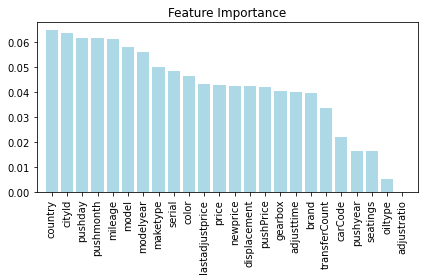

In [22]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feat_labels = df_train.columns[0:]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], color='lightblue', align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()
